In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import scipy
import time

In [39]:
def read_file(filename,r):
    data_file = 'data/' + filename + '.csv'
    label_file = 'data/labels-' + filename + '.csv'
    
    all_data = pd.read_csv(data_file, header = None).values
    all_labels = pd.read_csv(label_file, header = None).values
    
    N = len(all_labels)

    ind = range(N)
    random.shuffle(ind) # Randomly shuffle the indices
    
    if filename == 'irlstest': # Special case for 'irlstest'
        test_index = ind
        train_index = ind
    else:
        test_index = ind[0:int(N/3.0)]
        train_index = ind[int(N/3.0):int((1.0/3 + r * 2.0/3) * N)] # r is size rate of training examples
    
    train_data = all_data[train_index]
    train_label = all_labels[train_index]
    test_data = all_data[test_index]
    test_label = all_labels[test_index]
    
    return train_data, train_label, test_data, test_label

In [24]:
def prob_gen(filename, size):
    
    train_data, train_label, test_data, test_label = read_file(filename, size)
    
    c1_ind = np.where(train_label == 1)[0]
    c2_ind = np.where(train_label == 0)[0]
    
    train_1 = train_data[c1_ind]
    train_2 = train_data[c2_ind]
    
    mu_1 = train_1.mean(0)
    mu_2 = train_2.mean(0)
    
    N_1 = train_1.shape[0]
    N_2 = train_2.shape[0]
    N = N_1 + N_2
    p_1 = float(N_1)/N
    p_2 = float(N_2)/N
    
    M = train_data.shape[1]
    S1 = np.zeros([M,M])
    S2 = np.zeros([M,M])
    for n in range(N_1):
        S1 += np.outer(train_1[n] - mu_1, np.transpose(train_1[n] - mu_1))
    S1 = S1 / N_1
    for n in range(N_2):
        S2 += np.outer(train_2[n] - mu_2, np.transpose(train_2[n] - mu_2))
    S2 = S2 / N_2
    S = p_1 * S1 + p_2 * S2

    S_inv = np.linalg.inv(S)
    w = np.dot(S_inv, mu_1 - mu_2)
    w0 = - 1.0/2 * np.dot(mu_1, np.dot(S_inv, mu_1)) \
    + 1.0/2 * np.dot(mu_2, np.dot(S_inv, mu_2)) + np.log(p_1/p_2)
    
    # Testing
    vec = []
    for k in range(len(test_data)):
        a = np.dot(w,test_data[k]) + w0
        sigma = 1/(1 + np.exp(-a))
        if sigma >= 0.5:
            vec.append(int(test_label[k] == 1))
        else:
            vec.append(int(test_label[k] == 0))
    acc = float(sum(vec))/len(vec)
    
    return acc

In [47]:
def bay_log_reg(filename, size):
    
    train_data, train_label, test_data, test_label = read_file(filename, size)
    
    N = train_data.shape[0]
    ones = np.array([[1]]*N)
    train_data = np.concatenate((ones, train_data), axis = 1) # Add one column of ones to the features
    M = train_data.shape[1]

    phi = train_data
    t = train_label
    alpha = 0.1
    w = np.array([[0]]*M) # Initialize w as a column of 0 vector
    tol = 1
    n = 1


    while tol > 10**-3 and n < 100:
        
        w_old = w

        a = phi.dot(w_old)
        y = 1.0/(1 + np.exp(-a))
        r = y*(1-y)
        R = np.diag(r.ravel())
        I = np.eye(M)
        A = alpha * I + phi.T.dot(R.dot(phi))
        B = phi.T.dot(y - t) + alpha * w_old
        w_new = w_old - np.linalg.inv(A).dot(B)

        tol = np.linalg.norm(w_new - w_old) / np.linalg.norm(w_old)
        w = w_new
        n += 1 
    
#     print w
#     print w.shape
    a = phi.dot(w)
    y = 1.0/(1 + np.exp(-a))
    SN_inv = alpha * I
    for n in range(N):
        SN_inv += y[n]*(1-y[n]) * np.outer(phi[n],phi[n])
    SN = np.linalg.inv(SN_inv)
    print y
    # Testing
    ones = np.array([[1]]*test_data.shape[0])
    test_data = np.concatenate((ones, test_data), axis = 1)
    phi_test = test_data
    vec = []
    for n in range(test_data.shape[0]):
        mu_a = phi_test[n].dot(w)
        sigma_a_squared = phi_test[n].T.dot(SN.dot(phi_test[n]))
        kappa = (1 + np.pi * sigma_a_squared / 8) ** (-1.0/2)
        p = 1.0/(1 + np.exp( - kappa * mu_a))
        if p >= 0.5:
            vec.append(int(test_label[n] == 1))
        else:
            vec.append(int(test_label[n] == 0))
    acc = float(sum(vec))/len(vec)
    
    return acc

In [5]:
def plot_learning_curve(filename):
    size_vec = np.arange(0.1,1.1,0.1)
    acc_gen_vec = []
    acc_gen_err = []
    acc_bay_vec = []
    acc_bay_err = []
    for size in size_vec:
        acc_gen = []
        acc_bay = []
        for k in range(30):
            acc_gen.append(prob_gen(filename, size))
            acc_bay.append(bay_log_reg(filename, size))
        acc_gen_vec.append(np.mean(acc_gen))
        acc_gen_err.append(np.std(acc_gen))
        acc_bay_vec.append(np.mean(acc_bay))
        acc_bay_err.append(np.std(acc_bay))
    
    return size_vec, acc_gen_vec, acc_gen_err, acc_bay_vec, acc_bay_err

In [6]:
size_vec, acc_gen_vec, acc_gen_err, acc_bay_vec, acc_bay_err = plot_learning_curve('A')

(0, 1.1)

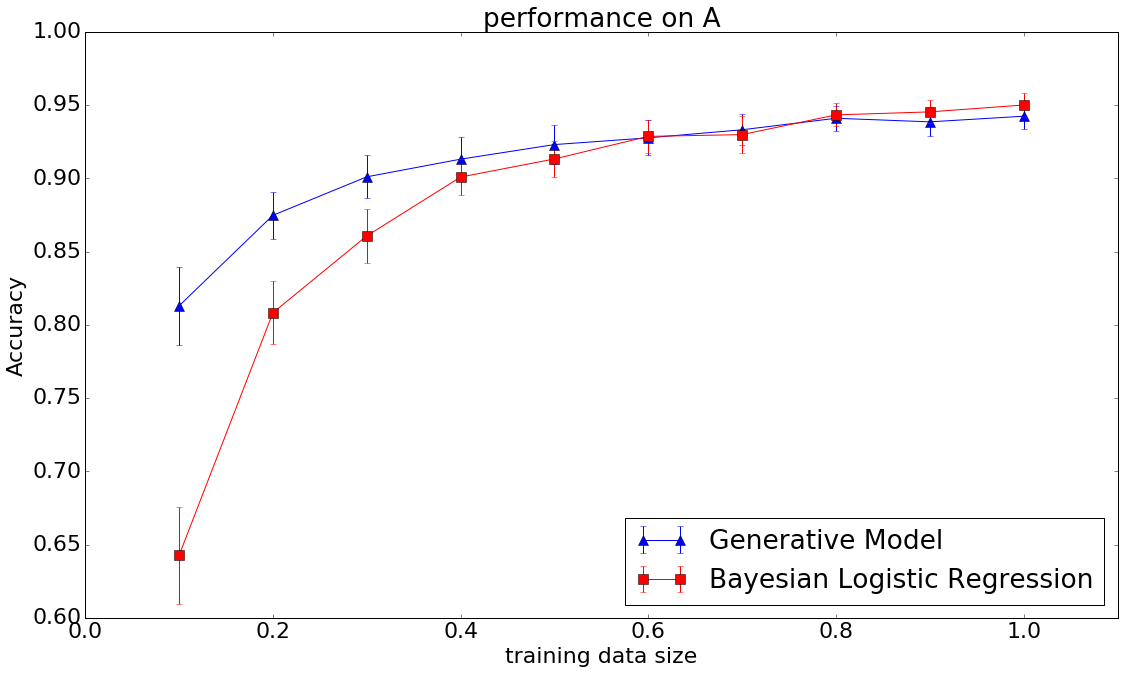

In [7]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
matplotlib.rcParams.update({'font.size': 22})
plt.errorbar(size_vec, acc_gen_vec, yerr = acc_gen_err, fmt = 'b-^', markersize = 10)
plt.errorbar(size_vec, acc_bay_vec, yerr = acc_bay_err, fmt = 'r-s', markersize = 10)
plt.xlabel('training data size')
plt.ylabel('Accuracy')
plt.title('performance on A')
plt.legend(['Generative Model','Bayesian Logistic Regression'], loc = 4)
plt.xlim(0,1.1)

## Discussion:


With set A, generative model works better than Bayesian Logistic Regression when trainning set size is small. As the size of trainning set grows, the performances of the two algorithms both improve and Bayesian Logistic Regression finally slightly outperfoms the generative model.

This is because the generative model uses the assumption that the data are drawn from different Gaussians with shared variance and different means. This is violated because our data is actually drawn from uniform distributions. However, when data size is small, this is not very far from the Gaussian assumption, and therefore the assumption could still be helpful for the classification. However, when data size is large, the Gaussian assumption is furtherly violated and won't help classification any more. That's why Bayesain Logisitic Regression finally outperfoms the generative model, for it does not use that assumption.

In [8]:
size_vec, acc_gen_vec, acc_gen_err, acc_bay_vec, acc_bay_err = plot_learning_curve('B')

(0, 1.1)

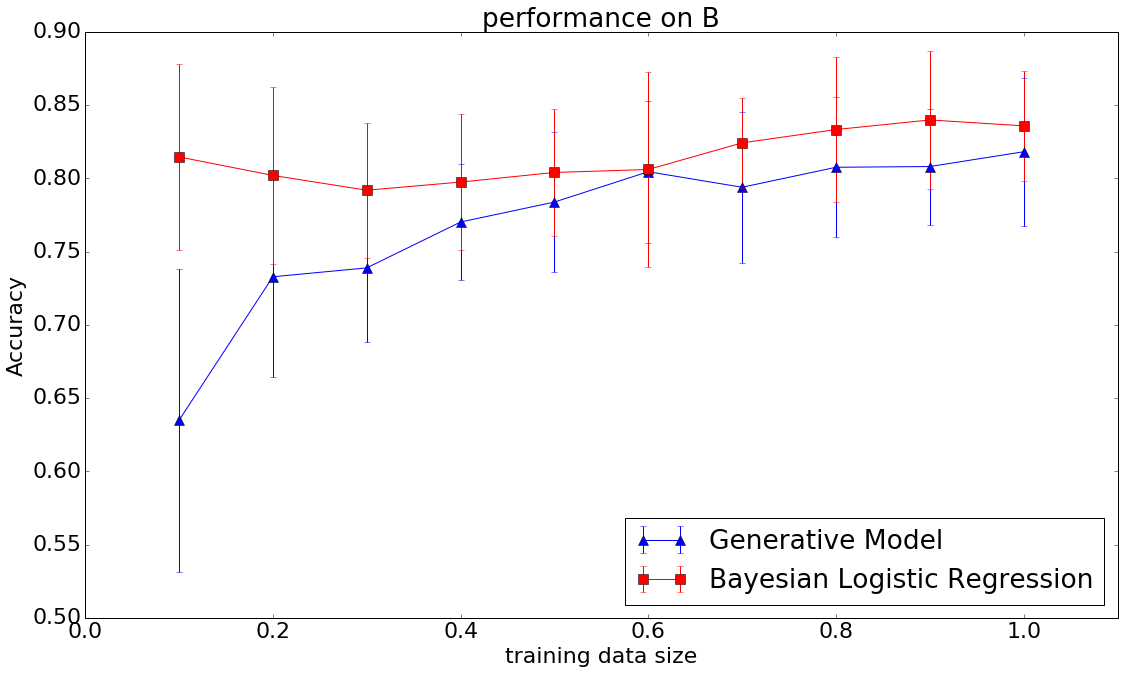

In [9]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
matplotlib.rcParams.update({'font.size': 22})
plt.errorbar(size_vec, acc_gen_vec, yerr = acc_gen_err, fmt = 'b-^', markersize = 10)
plt.errorbar(size_vec, acc_bay_vec, yerr = acc_bay_err, fmt = 'r-s', markersize = 10)
plt.xlabel('training data size')
plt.ylabel('Accuracy')
plt.title('performance on B')
plt.legend(['Generative Model','Bayesian Logistic Regression'], loc = 4)
plt.xlim(0,1.1)

## Discussion:

In this case, the Bayesian Logisitic Regression outperfoms the generative model entirely. This is because the way our data drawn diverges further from the Gaussian assumption that the generative model uses. However, the Bayesian Logistic Regression that do not need this assumption.

In [10]:
size_vec, acc_gen_vec, acc_gen_err, acc_bay_vec, acc_bay_err = plot_learning_curve('usps')

(0, 1.1)

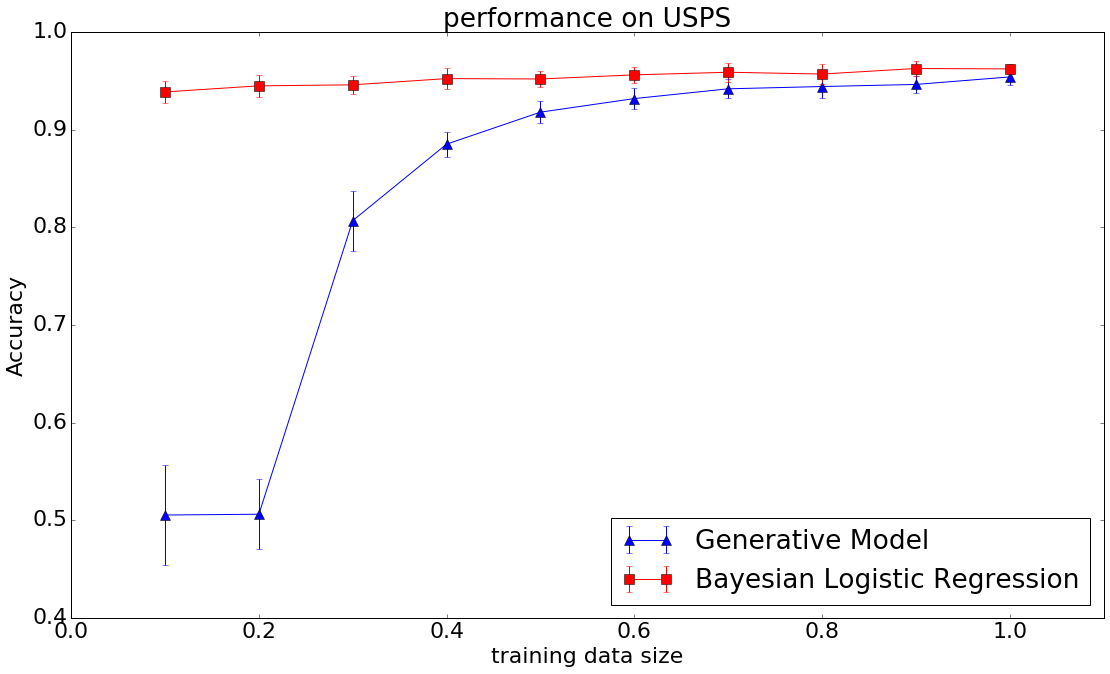

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
matplotlib.rcParams.update({'font.size': 22})
plt.errorbar(size_vec, acc_gen_vec, yerr = acc_gen_err, fmt = 'b-^', markersize = 10)
plt.errorbar(size_vec, acc_bay_vec, yerr = acc_bay_err, fmt = 'r-s', markersize = 10)
plt.xlabel('training data size')
plt.ylabel('Accuracy')
plt.title('performance on USPS')
plt.legend(['Generative Model','Bayesian Logistic Regression'], loc = 4)
plt.xlim(0,1.1)

## Discussion:

In this digit recognition practice, the Bayesian Logistic Regression outperforms the generative model entirely. Because, in practice, we know little about our data and hence there is little chance that the Gaussian assumption of the generative model could be met. Without information of the intrinsic distribution of the data, it is very likely that the Bayesian Logistic Regression outperfoms the generative model in application.

## Summary:

The generative model uses a strong assumption while the Bayesian Logistic Regression does not. 

In application, if we know much information about the distribution of the data, and it is close to the Gaussian assumption. Then we can choose the generative model for its simplicity in math, easy to implement and fast in run time.

However, in most cases, when we know little about the distribution of the data or we know that it diverges far from the Gaussian assumption, we use Bayesian Logistice Regression.

## Task 2: Newton's method vs. gradient ascent

In [12]:
def BLR_NEWTON(filename):
    # Read in files
    data_file = 'data/' + filename + '.csv'
    label_file = 'data/labels-' + filename + '.csv'
    
    all_data = pd.read_csv(data_file, header = None).values
    all_labels = pd.read_csv(label_file, header = None).values
    
    N = len(all_labels)

    ind = range(N)
    test_index = ind[0:int(N/3.0)]
    train_index = ind[int(N/3.0):N]
    
    train_data = all_data[train_index]
    train_label = all_labels[train_index]
    test_data = all_data[test_index]
    test_label = all_labels[test_index]
    
    N = train_data.shape[0]
    ones = np.array([[1]]*N)
    train_data = np.concatenate((ones, train_data), axis = 1)
    M = train_data.shape[1]
    
    # Training
    phi = train_data
    t = train_label
    alpha = 0.1
    w = np.array([[0]]*M)
    tol = 1
    n = 1
    
    time_lapse = [0]
    w_vec = [w]
    start = time.time()
    while tol > 10**-3 and n < 100:
        w_old = w

        a = phi.dot(w_old)
        y = 1.0/(1 + np.exp(-a))
        r = y*(1-y)
        R = np.diag(r.ravel())
        I = np.eye(M)
        A = alpha * I + phi.T.dot(R.dot(phi))
        B = phi.T.dot(y - t) + alpha * w_old
        w_new = w_old - np.linalg.inv(A).dot(B) # Newton's Method

        tol = np.linalg.norm(w_new - w_old) / np.linalg.norm(w_old)
        w = w_new
        n += 1
        time_lapse.append(time.time()-start) # Record runtime every iteration
        w_vec.append(w)
    
    
    # Testing
    ones = np.array([[1]]*test_data.shape[0])
    test_data = np.concatenate((ones, test_data), axis = 1)
    phi_test = test_data
    acc_vec = []
    for w in w_vec:
        a = phi.dot(w)
        y = 1.0/(1 + np.exp(-a))
        SN_inv = alpha * I
        for n in range(N):
            SN_inv += y[n]*(1-y[n]) * np.outer(phi[n],phi[n])
        SN = np.linalg.inv(SN_inv)

        vec = []
        for n in range(test_data.shape[0]):
            mu_a = phi_test[n].dot(w)
            sigma_a_squared = phi_test[n].T.dot(SN.dot(phi_test[n]))
            kappa = (1 + np.pi * sigma_a_squared / 8) ** (-1.0/2)
            p = 1.0/(1 + np.exp( - kappa * mu_a))
            if p >= 0.5:
                vec.append(int(test_label[n] == 1))
            else:
                vec.append(int(test_label[n] == 0))
        acc = float(sum(vec))/len(vec)
        acc_vec.append(acc)
        
    return w_vec, time_lapse, acc_vec

In [13]:
def BLR_GRADASC(filename,eta):
    # Read in files
    data_file = 'data/' + filename + '.csv'
    label_file = 'data/labels-' + filename + '.csv'
    
    all_data = pd.read_csv(data_file, header = None).values
    all_labels = pd.read_csv(label_file, header = None).values
    
    N = len(all_labels)

    ind = range(N)
    test_index = ind[0:int(N/3.0)]
    train_index = ind[int(N/3.0):N]
    
    train_data = all_data[train_index]
    train_label = all_labels[train_index]
    test_data = all_data[test_index]
    test_label = all_labels[test_index]
    
    N = train_data.shape[0]
    ones = np.array([[1]]*N)
    train_data = np.concatenate((ones, train_data), axis = 1)
    M = train_data.shape[1]
    
    # Training
    phi = train_data
    t = train_label
    alpha = 0.1
    w = np.array([[0]]*M)
    tol = 1
    n = 1
    
    time_lapse = [0]
    w_vec = [w]
    start = time.time()
    while tol > 10**-3 and n < 6000:
        
        w_old = w

        a = phi.dot(w_old)
        y = 1.0/(1 + np.exp(-a))
        w_new = w_old - eta * (phi.T.dot(y - t) + alpha * w_old) # Gradient Ascent

        tol = np.linalg.norm(w_new - w_old) / np.linalg.norm(w_old)
        w = w_new
        n += 1
        
        if n%50 == 0: # Record run time every 50 iterations
            time_lapse.append(time.time()-start)
            w_vec.append(w)
    
    # Testing
    ones = np.array([[1]]*test_data.shape[0])
    test_data = np.concatenate((ones, test_data), axis = 1)
    phi_test = test_data
    I = np.eye(M)
    acc_vec = []
    for w in w_vec:
        a = phi.dot(w)
        y = 1.0/(1 + np.exp(-a))
        SN_inv = alpha * I
        for n in range(N):
            SN_inv += y[n]*(1-y[n]) * np.outer(phi[n],phi[n])
        SN = np.linalg.inv(SN_inv)

        vec = []
        for n in range(test_data.shape[0]):
            mu_a = phi_test[n].dot(w)
            sigma_a_squared = phi_test[n].T.dot(SN.dot(phi_test[n]))
            kappa = (1 + np.pi * sigma_a_squared / 8) ** (-1.0/2)
            p = 1.0/(1 + np.exp( - kappa * mu_a))
            if p >= 0.5:
                vec.append(int(test_label[n] == 1))
            else:
                vec.append(int(test_label[n] == 0))
        acc = float(sum(vec))/len(vec)
        acc_vec.append(acc)
        
    return w_vec, time_lapse, acc_vec

In [14]:
w_newton1, time_newton1, acc_newton1 = BLR_NEWTON('A')
w_newton2, time_newton2, acc_newton2 = BLR_NEWTON('A')
w_newton3, time_newton3, acc_newton3 = BLR_NEWTON('A')
time_newton = (np.array(time_newton1) + np.array(time_newton2) + np.array(time_newton3))/3.0
acc_newton = (np.array(acc_newton1) + np.array(acc_newton2) + np.array(acc_newton3))/3.0

In [15]:
w_gradasc1, time_gradasc1, acc_gradasc1 = BLR_GRADASC('A',0.001)
w_gradasc2, time_gradasc2, acc_gradasc2 = BLR_GRADASC('A',0.001)
w_gradasc3, time_gradasc3, acc_gradasc3 = BLR_GRADASC('A',0.001)
time_gradasc = (np.array(time_gradasc1) + np.array(time_gradasc2) + np.array(time_gradasc3))/3.0
acc_gradasc = (np.array(acc_gradasc1) + np.array(acc_gradasc2) + np.array(acc_gradasc3))/3.0

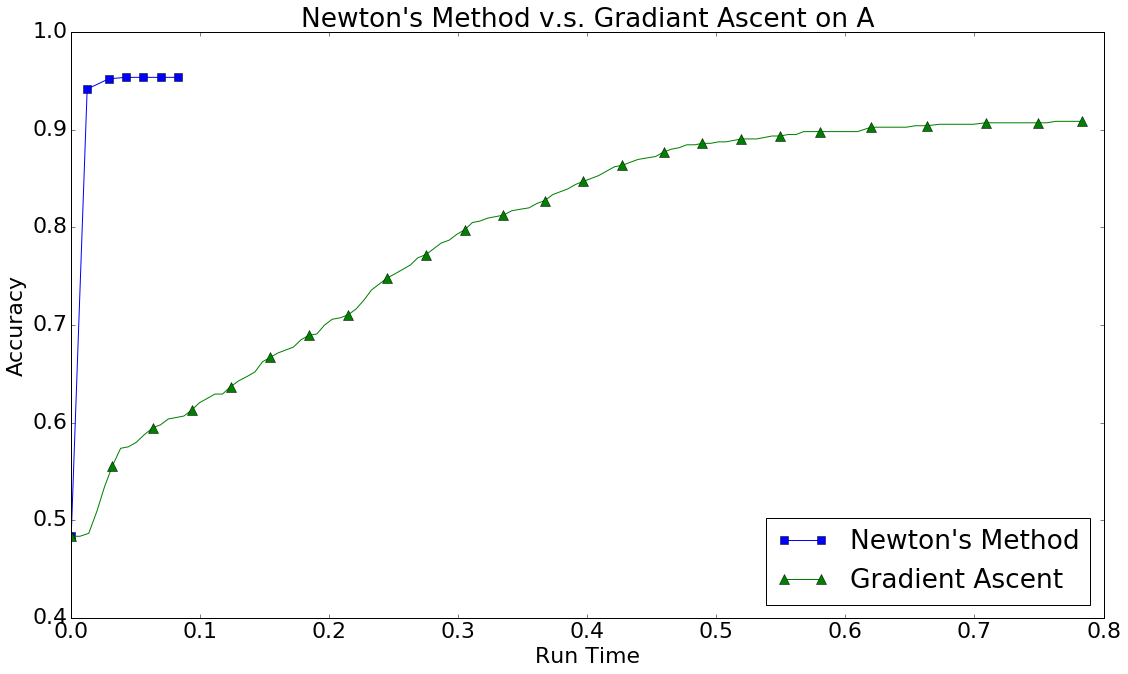

In [16]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
matplotlib.rcParams.update({'font.size': 22})
plt.plot(time_newton,acc_newton,'-s', markersize = 8)
plt.plot(time_gradasc,acc_gradasc,'-^', markersize = 10, markevery = 5)
plt.xlabel('Run Time')
plt.ylabel("Accuracy")
plt.title("Newton's Method v.s. Gradiant Ascent on A")
plt.legend(["Newton's Method","Gradient Ascent"],loc = 4)

## Discussion:

* We compare the Newton-Raphson method v.s. Gradient Ascent with step size $\eta = 0.001$ on trainning set A. For each iteration, Newton-Raphson took much longer in the runtime. It took approximately **0.0128** second for one iteration of the Newton-Raphson, while only about **0.00012** second for one iteration of the Gradient Ascent. Nearly **100** time faster.


* However, it took much fewer iterations for the Newton-Raphon to converge than Gradient Ascent. For Newton-Raphson, it took only 6 iterations to converge, while for the Gradient Ascent, it hit the upper bound ($n = 6000$) on the number of iterations yet not fully converged to the result from Newton-Raphson.


* Therefore, Newton-Raphson took much less the total runtime than Gradient Ascent. This is because with fixed step size, the convergence of the Gradient Ascent will slow down with the number of iterations. The gradient will be flatter and flatter when we are approaching to the local maximum, and hence our updates $\eta \nabla f$ will be smaller and smaller. To fix this problem, an adaptive step size approach should be considered when applying Gradient Ascent. This is discussed in the extra credit part of this project.


* On the contrary, Newton-Raphson involves the computation of the inverse of a matrix. Although this is considered to be both difficult mathematically and costy computationally, once done, it converges very fast and gives very good result. Therefore, it might be worth of doing this in the application whenever it is possible to compute the Hessian matrix and the inverse of it.

In [17]:
w_newton1, time_newton1, acc_newton1 = BLR_NEWTON('usps')
w_newton2, time_newton2, acc_newton2 = BLR_NEWTON('usps')
w_newton3, time_newton3, acc_newton3 = BLR_NEWTON('usps')
time_newton = (np.array(time_newton1) + np.array(time_newton2) + np.array(time_newton3))/3.0
acc_newton = (np.array(acc_newton1) + np.array(acc_newton2) + np.array(acc_newton3))/3.0

In [18]:
w_gradasc1, time_gradasc1, acc_gradasc1 = BLR_GRADASC('usps',0.001)
w_gradasc2, time_gradasc2, acc_gradasc2 = BLR_GRADASC('usps',0.001)
w_gradasc3, time_gradasc3, acc_gradasc3 = BLR_GRADASC('usps',0.001)
time_gradasc = (np.array(time_gradasc1) + np.array(time_gradasc2) + np.array(time_gradasc3))/3.0
acc_gradasc = (np.array(acc_gradasc1) + np.array(acc_gradasc2) + np.array(acc_gradasc3))/3.0

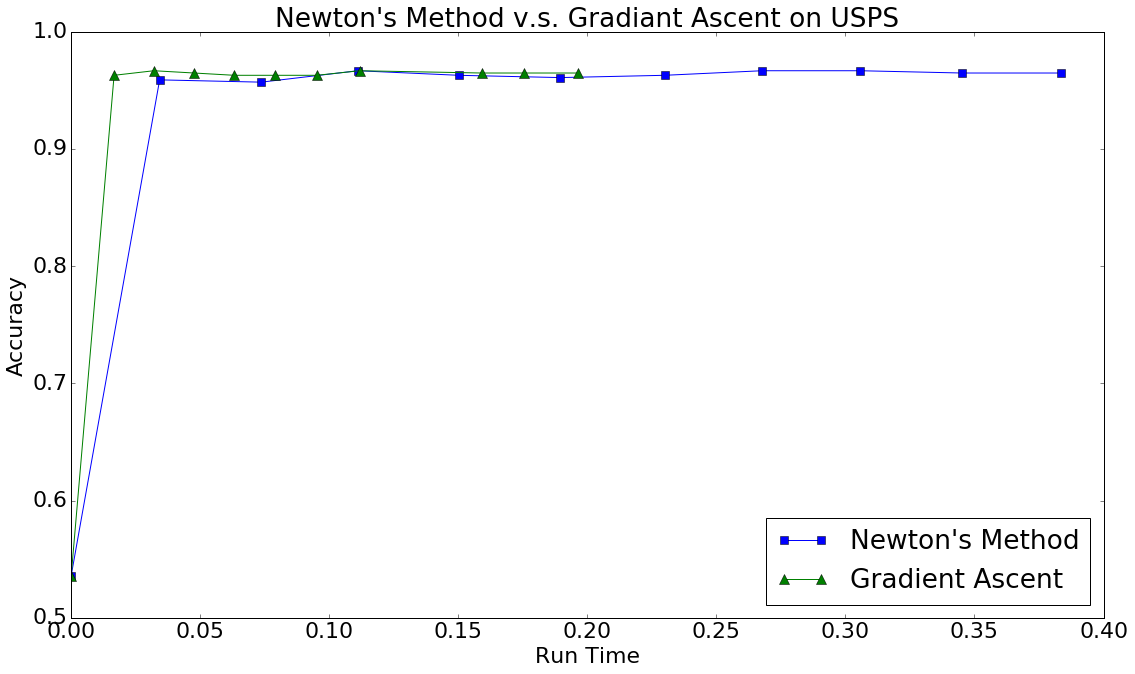

In [19]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
matplotlib.rcParams.update({'font.size': 22})
plt.plot(time_newton,acc_newton,'-s', markersize = 8)
plt.plot(time_gradasc,acc_gradasc,'-^', markersize = 10)
plt.xlabel('Run Time')
plt.ylabel("Accuracy")
plt.title("Newton's Method v.s. Gradiant Ascent on USPS")
plt.legend(["Newton's Method","Gradient Ascent"],loc = 4)

## Discussion:

* We compare the Newton-Raphson method v.s. Gradient Ascent with step size $\eta = 0.001$ on trainning set USPS. For each iteration, Newton-Raphson took much longer in the runtime. It took approximately **0.042** second for one iteration of the Newton-Raphson, while only about **0.00025** second for one iteration of the Gradient Ascent. Still nearly **100** time faster.


* It took much fewer iterations for the Newton-Raphon to converge than Gradient Ascent. For Newton-Raphson, it took **10** iterations to converge, while for the Gradient Ascent, it took about **510** iterations to converge.


* In this case, Newton-Raphson took longer the total runtime than Gradient Ascent to converge. However, notice that they actually both reached a fairly high accuracy within a very small number of iterations. It is the noise that makes the convergence took more iterations, however the accuracy didn't improve much. It is the nature of this problem that allows the classifier to converge quickly.

## Summary:

Compared to Gradient Ascent, Newton-Raphson needs much longer run time to compute each iteration but much less number of iterations to converge.

In practice, we should use Newton-Raphson when:
* Computing the Hessian matrix and its inverse is not very time consuming. This is usually true when the number of features is not very large.
    
* The gradient of the maxization/minimization problem is flat, so that Gradient Ascent/Descent would converge very slowly.

We should use Gradient Ascent/Descent when:
* It is mathematically impossible or computationally expensive to compute the Hessian matrix and its inverse.

* The gradient of the maximization/minimization problem is steep, so that Gradient Ascent/Descent would converge quickly.

* Consider an adaptive step size scheme.

## Extra Credit

## Sensitivity of step size

In [20]:
def BLR_FIXGRADASC(filename,eta):
    # Read in files
    data_file = 'data/' + filename + '.csv'
    label_file = 'data/labels-' + filename + '.csv'
    
    all_data = pd.read_csv(data_file, header = None).values
    all_labels = pd.read_csv(label_file, header = None).values
    
    N = len(all_labels)

    ind = range(N)
    test_index = ind
    train_index = ind
    
    train_data = all_data[train_index]
    train_label = all_labels[train_index]
    test_data = all_data[test_index]
    test_label = all_labels[test_index]
    
    N = train_data.shape[0]
    ones = np.array([[1]]*N)
    train_data = np.concatenate((ones, train_data), axis = 1)
    M = train_data.shape[1]
    
    # Training
    phi = train_data
    t = train_label
    alpha = 0.1
    w = np.array([[0]]*M)
    tol = 1
    n = 1
    
    time_lapse = [0]
    w_vec = [w]
    start = time.time()
    while tol > 10**-3 and n < 6000:
        
        w_old = w

        a = phi.dot(w_old)
        y = 1.0/(1 + np.exp(-a))
#         print eta
        w_new = w_old - eta * (phi.T.dot(y - t) + alpha * w_old) # Gradient Ascent

        tol = np.linalg.norm(w_new - w_old) / np.linalg.norm(w_old)
        w = w_new
        n += 1
        
        time_lapse.append(time.time()-start)
        w_vec.append(w)
    print n
    
    # Testing
    ones = np.array([[1]]*test_data.shape[0])
    test_data = np.concatenate((ones, test_data), axis = 1)
    phi_test = test_data
    I = np.eye(M)
    acc_vec = []
    for w in w_vec:
        a = phi.dot(w)
        y = 1.0/(1 + np.exp(-a))
        SN_inv = alpha * I
        for n in range(N):
            SN_inv += y[n]*(1-y[n]) * np.outer(phi[n],phi[n])
        SN = np.linalg.inv(SN_inv)

        vec = []
        for n in range(test_data.shape[0]):
            mu_a = phi_test[n].dot(w)
            sigma_a_squared = phi_test[n].T.dot(SN.dot(phi_test[n]))
            kappa = (1 + np.pi * sigma_a_squared / 8) ** (-1.0/2)
            p = 1.0/(1 + np.exp( - kappa * mu_a))
            if p >= 0.5:
                vec.append(int(test_label[n] == 1))
            else:
                vec.append(int(test_label[n] == 0))
        acc = float(sum(vec))/len(vec)
        acc_vec.append(acc)
        
    return w_vec, time_lapse, acc_vec

In [21]:
w_vec1, time_lapse1, acc_vec1 = BLR_FIXGRADASC('irlstest',0.001)
w_vec2, time_lapse2, acc_vec2 = BLR_FIXGRADASC('irlstest',0.01)
w_vec3, time_lapse3, acc_vec3 = BLR_FIXGRADASC('irlstest',0.1)

196
42
6000


(0, 0.01)

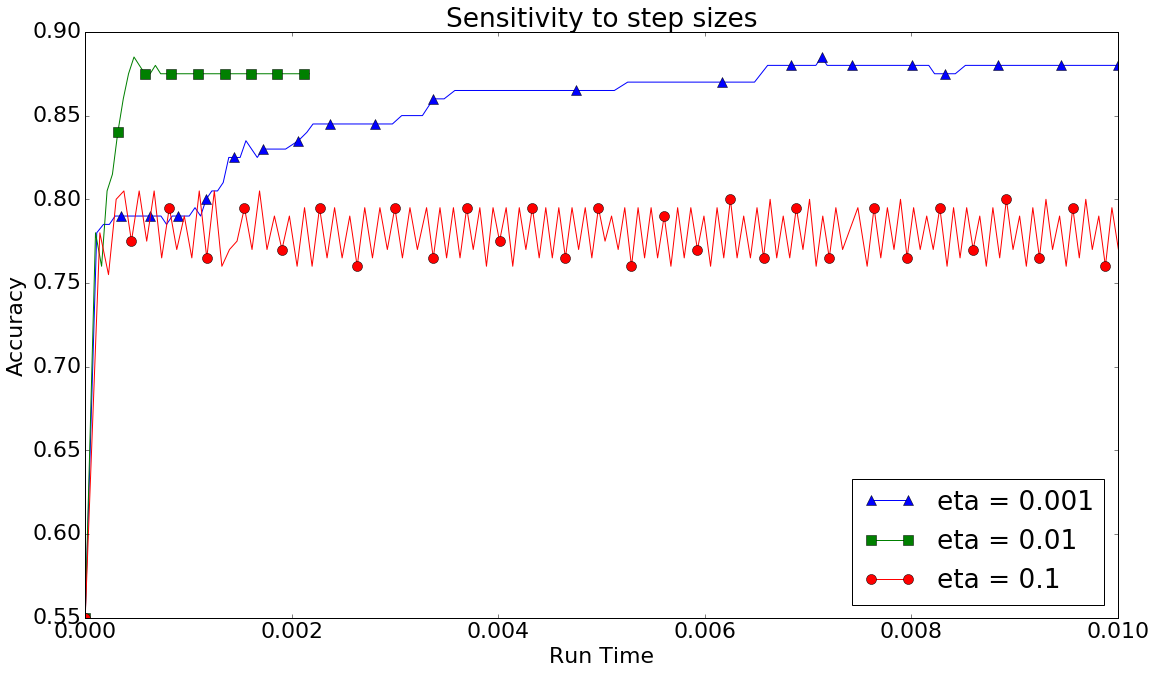

In [22]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
matplotlib.rcParams.update({'font.size': 22})
plt.plot(time_lapse1,acc_vec1,'-^',markevery =5,markersize=10)
plt.plot(time_lapse2,acc_vec2,'-s',markevery =5,markersize=10)
plt.plot(time_lapse3,acc_vec3,'-o',markevery =5,markersize=10)
plt.legend(['eta = 0.001', 'eta = 0.01', 'eta = 0.1'], loc = 4)
plt.xlabel('Run Time')
plt.ylabel('Accuracy')
plt.title('Sensitivity to step sizes')
plt.xlim(0,0.01)

## Discussion:
Gradient Descent is very sensitive to step sizes. For small step size ($\eta = 0.001$), it converges but very slowly. For moderate step size ($\eta = 0.01$), it converges fastly. For too large step size ($\eta = 0.1$) it does not converge. The solution oscilates back and forth around the minimum.

## Backtracking line search:
The idea of the line search is that, we adaptively search for the right step size for the gradient descent in every iteration. Here we implement a backtracking line search algorithm. The algorithm is as follows:

* Firstly choose $\beta = \frac{1}{2}$

* At each iteration, begin with $\eta = 1$, and while
$$f\big(w - \eta \nabla f(w)\big) - f(w) > -\frac{\eta}{2} \big\|\nabla f(w)\big\|^2$$
update $\eta = \beta \eta$

In [23]:
def BLR_ADPGRADASC(filename):
    # Read in files
    data_file = 'data/' + filename + '.csv'
    label_file = 'data/labels-' + filename + '.csv'
    
    all_data = pd.read_csv(data_file, header = None).values
    all_labels = pd.read_csv(label_file, header = None).values
    
    N = len(all_labels)

    ind = range(N)
    test_index = ind
    train_index = ind
    
    train_data = all_data[train_index]
    train_label = all_labels[train_index]
    test_data = all_data[test_index]
    test_label = all_labels[test_index]
    
    N = train_data.shape[0]
    ones = np.array([[1]]*N)
    train_data = np.concatenate((ones, train_data), axis = 1)
    M = train_data.shape[1]
    
    # Training
    phi = train_data
    t = train_label
    alpha = 0.1
    w = np.array([[0]]*M)
    tol = 1
    n = 1
    
    while tol > 10**-3 and n < 6000:
        
        w_old = w

        a = phi.dot(w_old)
        y = 1.0/(1 + np.exp(-a))
        
        # Backtracking line search
        eta = 1
        beta = 0.5
        grad = phi.T.dot(y - t)
        do = 1
        n_iter = 0
        while do:
            f = -np.log(y**t*(1-y)**(1-t)).sum()
            w_delta = w_old - eta * grad
            a_delta = phi.dot(w_delta)
            y_delta = 1.0/(1 + np.exp(-a_delta))
            f_delta = -np.log(y_delta**t*(1-y_delta)**(1-t)).sum()
#             print f_delta - f
            if f_delta - f > -eta/2.0*grad.T.dot(grad):
                eta = beta * eta
            else:
                do = 0
        
        print eta
        w_new = w_old - eta * (grad + alpha * w_old) # Gradient Descent

        tol = np.linalg.norm(w_new - w_old) / np.linalg.norm(w_old)
        w = w_new
        n += 1
    print n
        
    return w

In [24]:
w = BLR_ADPGRADASC('irlstest')

0.0009765625
0.00390625
0.03125
0.0078125
0.0078125
0.0078125
0.015625
0.00390625
0.03125
0.00390625
0.0078125
0.03125
0.00390625
0.0078125
0.03125
0.00390625
0.015625
0.0078125
0.015625
0.0078125
0.03125
0.00390625
0.015625
0.0078125
0.015625
0.0078125
0.03125
0.00390625
0.015625
0.0078125
0.015625
0.0078125
0.03125
0.0078125
0.015625
0.0078125
0.015625
0.0078125
39


In [25]:
print w

[[-1.62491904]
 [-0.11858071]
 [-0.09403808]
 [-0.02863587]
 [-0.05103497]
 [-0.04438634]
 [ 0.65684343]
 [ 0.56309479]
 [ 0.82164765]
 [ 0.54018102]
 [ 0.27141533]]


## Discussion:
With line search, we can see that the step sizes $\eta$ is changing with every iteration, and the overall convergence is faster than the fixed case. It only needs **39** iterations to converge, compared to **169** iterations for the $\eta = 0.001$ case and **42** iterations for the $\eta = 0.01$ case.